In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

In [2]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

TIM.Daz = 1 * u.deg
TIM.Del = 1 * u.deg
# TIM.SW.dnu = TIM.SW.dnu
# TIM.LW.dnu = TIM.LW.dnu
# TIM.SW.NEI = 7.9e6 * u.Jy * u.s**0.5
# TIM.LW.NEI = 3.2e6 * u.Jy * u.s**0.5
# TIM.SW.NEI = .17e6 * u.Jy * u.s**0.5
# TIM.LW.NEI = .13e6 * u.Jy * u.s**0.5
mirror_ratio = 1 # 2 m to 50 cm
for band in ['SW', 'LW']:
    TIM[band].ins = ut.Instrument(TIM[band].NEI, TIM[band].FWHM * mirror_ratio, \
            TIM[band].dnu, TIM[band].num_dets)
TIM.time = 200 * u.hr

In [3]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [4]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bands = ['SW', 'SW', 'LW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/2140040013.py:19: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/2140040013.py:36: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/2140040013.py:37: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/2140040013.py:38: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [5]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [TIM[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [TIM[band].min for band in bands]
insmaxs = [TIM[band].max for band in bands]
insdnu = [TIM[band].dnu for band in bands]
linenu = l.CII.nu
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnu)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
# KSs = [np.logspace(-3, 3, 50) for _ in datas]  # use common k-bins
psCIIs = [data['ps_cii'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_single(TIM[band].NEI, TIM.time, TIM[band].num_dets, CALCZ, TIM.Daz, TIM.Del, TIM[band].dnu, l.CII.nu) for CALCZ, band in zip(CALCZs, bands)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((kxs[i].flat[binnedidxs[i] == j] != 0) & (kys[i].flat[binnedidxs[i] == j] != 0) & (kzs[i].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


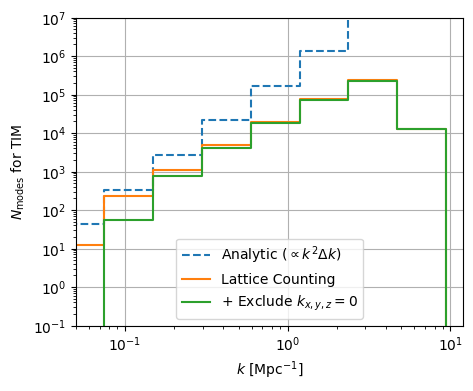

In [6]:
zidx = 2
ks = KSs[zidx][1:-1]
dks = (kbinedges[zidx][1:] - kbinedges[zidx][:-1])
nmodes_analytic = 2 * np.pi * ks**2 * dks / ( (2 * np.pi)**3 / 
    (L_xy(CALCZs[zidx], TIM.Daz) * L_xy(CALCZs[zidx], TIM.Del) * L_z(CALCZs[zidx], TIM[bands[zidx]].min, TIM[bands[zidx]].max, linenu)) )
plt.figure(figsize=(5, 4))
plt.step(ks, nmodes_analytic, label=r'Analytic ($\propto k^2 \Delta k$)', linestyle='dashed')
plt.step(ks, Nmodes_ones[zidx], label='Lattice Counting')
plt.step(ks, Nmodes_Z[zidx], label=r'+ Exclude $k_{x, y, z} = 0$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$N_\text{modes}$ for TIM')
plt.xlim(0.5e-1, 1.2e1)
plt.ylim(1e-1, 1e7)
plt.grid()
plt.legend()
plt.loglog()
# plt.savefig('../figs/modes/nmodes_comp.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/914417675.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(kperp.flat, kz.flat, s=1, alpha=.5, c=np.log10(km.flat), cmap='viridis')


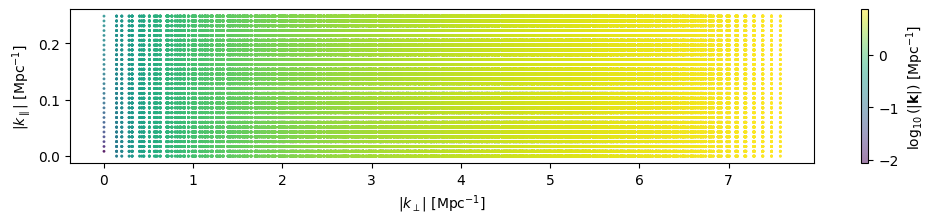

In [7]:
zidx = 2
km = k_mags[zidx]
kz = np.abs(kzs[zidx])
kperp = np.sqrt(km**2 - kz**2)

plt.figure(figsize=(12, 2))
plt.scatter(kperp.flat, kz.flat, s=1, alpha=.5, c=np.log10(km.flat), cmap='viridis')
plt.xlabel(r'$|k_\perp|$ [Mpc$^{-1}$]')
plt.ylabel(r'$|k_\parallel|$ [Mpc$^{-1}$]')
plt.colorbar(label=r'$\log_{10}(|\mathbf{k}|)$ [Mpc$^{-1}$]')
# plt.grid()
# plt.savefig('../figs/modes/kperp_kpara_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_39850/2124165767.py:8: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(km.flat[randidxs]), cmap='viridis',
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_39850/2124165767.py:5: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(kxs[zidx].flat[randidxs],


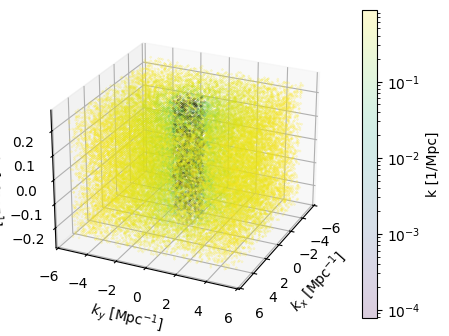

In [165]:
zidx = 2
sparse_factor = 10
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(6, 4))
randidxs = np.random.choice(km.size, size=km.size // sparse_factor, replace=False)
ax.scatter(kxs[zidx].flat[randidxs], 
        kys[zidx].flat[randidxs], 
        kzs[zidx].flat[randidxs], s=1, alpha=.2, marker='x',
        c=np.log10(km.flat[randidxs]), cmap='viridis',
            edgecolor='none', norm=plt.cm.colors.LogNorm())
ax.view_init(elev=25, azim=25)
ax.set_xlabel(r'$k_x$ [Mpc$^{-1}$]')
ax.set_ylabel(r'$k_y$ [Mpc$^{-1}$]')
ax.set_zlabel(r'$k_z$ [Mpc$^{-1}$]')
plt.colorbar(ax.collections[0], ax=ax, label='k [1/Mpc]', orientation='vertical')
plt.show()

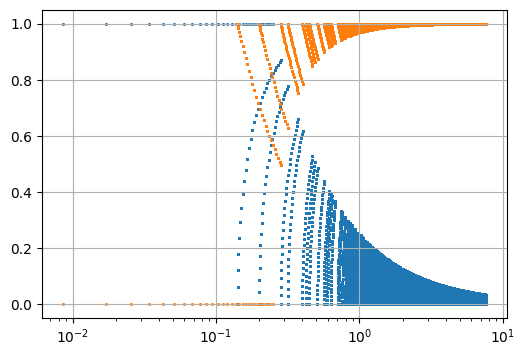

In [8]:
zidx = 2
km = k_mags[zidx]
mupara = np.abs(muz[zidx])
muperp = np.sqrt(1 - mupara**2)

plt.figure(figsize=(6, 4))
plt.scatter(km.flat, mupara.flat, s=1, alpha=1)
plt.scatter(km.flat, muperp.flat, s=1, alpha=1)
plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.savefig('../figs/modes/kperp_kpara_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

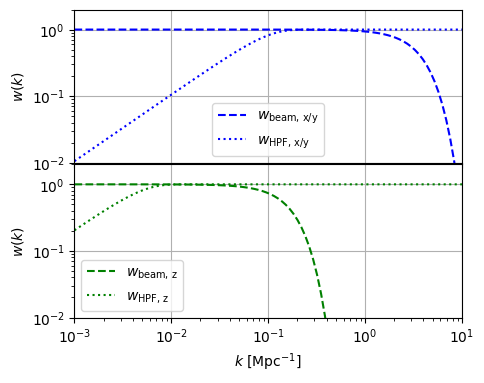

In [9]:
zidx = 2
ks = np.logspace(-3, 1, 100)
wbeamx = wbeam_m(ks, sigxs[zidx])
wbeamy = wbeam_m(ks, sigys[zidx])
wbeamz = wbeam_m(ks, sigzs[zidx])
whpfx = whpf_m(ks, kminxs[zidx])
whpfy = whpf_m(ks, kminys[zidx])
whpfz = whpf_m(ks, kminzs[zidx])
wtotal_ks = wbeamx * wbeamy * wbeamz * whpfx * whpfy * whpfz

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
plt.subplots_adjust(hspace=0.01)

ax1.plot(ks, wbeamx, label=r'$w_\text{beam, x/y}$', linestyle='dashed', color='blue')
ax2.plot(ks, wbeamz, label=r'$w_\text{beam, z}$', linestyle='dashed', color='green')
ax1.plot(ks, whpfx, label=r'$w_\text{HPF, x/y}$', linestyle='dotted', color='blue')
ax2.plot(ks, whpfz, label=r'$w_\text{HPF, z}$', linestyle='dotted', color='green')
for ax in (ax1, ax2):
    ax.loglog()
    ax.grid()
    ax.set_ylim(1e-2, 2)
    ax.set_xlim(1e-3, 1e1)
    ax.legend()
    ax.set_ylabel(r'$w(k)$')
ax2.set_xlabel(r'$k$ [Mpc$^{-1}$]')
# plt.savefig('../figs/modes/window_funcs.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1367026105.py:6: RuntimeWarning: divide by zero encountered in divide
  Pvar_real = np.sqrt([(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1367026105.py:7: RuntimeWarning: divide by zero encountered in divide
  Pvar_winnaive = np.sqrt([(psCII + Pn) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1367026105.py:8: RuntimeWarning: divide by zero encountered in divide
  Pvar_modesnaive = np.sqrt([(psCII + Pn / bw) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])


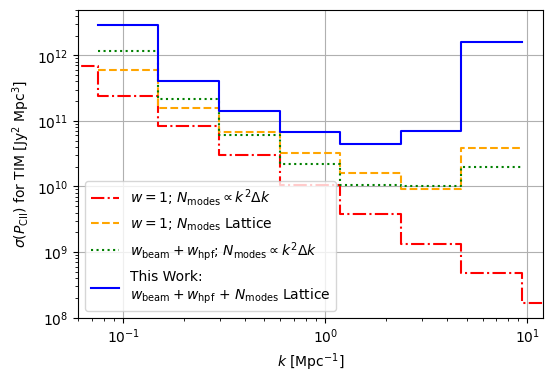

In [10]:
zidx = 2
ks = KSs[zidx][1:-1]
dks = (kbinedges[zidx][1:] - kbinedges[zidx][:-1])
nmodes_analytic = 2 * np.pi * ks**2 * dks / ( (2 * np.pi)**3 / (L_xy(CALCZs[zidx], TIM.Daz) * L_xy(CALCZs[zidx], TIM.Del) * L_z(CALCZs[zidx], TIM[bands[zidx]].min, TIM[bands[zidx]].max, linenu)) )

Pvar_real = np.sqrt([(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
Pvar_winnaive = np.sqrt([(psCII + Pn) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
Pvar_modesnaive = np.sqrt([(psCII + Pn / bw) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])
Pvar_modeswinnaive = np.sqrt([(psCII + Pn) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])

plt.figure(figsize=(6, 4))
plt.step(ks, Pvar_modeswinnaive, label=r'$w = 1$; $N_\text{modes} \propto k^2 \Delta k$', linestyle='dashdot', color='red')
plt.step(ks, Pvar_winnaive, label=r'$w = 1$; $N_\text{modes}$ Lattice', linestyle='dashed', color='orange')
plt.step(ks, Pvar_modesnaive, label=r'$w_\text{beam} + w_\text{hpf}$; $N_\text{modes} \propto k^2 \Delta k$', linestyle='dotted', color='green')
plt.step(ks, Pvar_real, label=r'This Work:' '\n' r'$w_\text{beam} + w_\text{hpf}$ + $N_\text{modes}$ Lattice', color='blue')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\sigma({P_\mathrm{CII}})$ for TIM [Jy$^2$ Mpc$^3$]')
plt.xlim(0.6e-1, 1.2e1)
plt.ylim(1e8, 5e12)
plt.grid()
plt.legend()
plt.loglog()
# plt.savefig('../figs/modes/pvar_comp.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1479306612.py:54: RuntimeWarning: divide by zero encountered in divide
  Pvar_real = np.sqrt([(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1479306612.py:55: RuntimeWarning: divide by zero encountered in divide
  Pvar_winnaive = np.sqrt([(psCII + Pn) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_90016/1479306612.py:56: RuntimeWarning: divide by zero encountered in divide
  Pvar_modesnaive = np.sqrt([(psCII + Pn / bw) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])


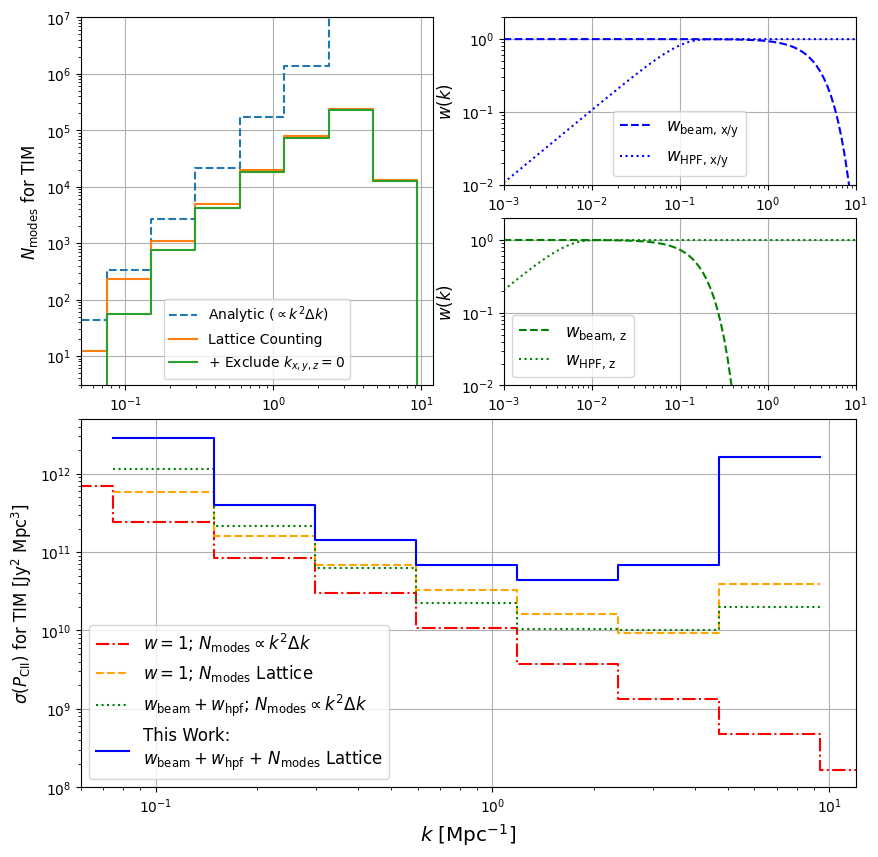

In [44]:
# make a grid spec plot with 2 on first row and 1 on second row
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2, figure=fig)

ax_step = fig.add_subplot(gs[0:2, 0])
axw1 = fig.add_subplot(gs[0, 1])
axw2 = fig.add_subplot(gs[1, 1])
ax_noise = fig.add_subplot(gs[2:, :])

zidx = 2
ks = KSs[zidx][1:-1]
dks = (kbinedges[zidx][1:] - kbinedges[zidx][:-1])
nmodes_analytic = 2 * np.pi * ks**2 * dks / ( (2 * np.pi)**3 / 
    (L_xy(CALCZs[zidx], TIM.Daz) * L_xy(CALCZs[zidx], TIM.Del) * L_z(CALCZs[zidx], TIM[bands[zidx]].min, TIM[bands[zidx]].max, linenu)) )
ax_step.step(ks, nmodes_analytic, label=r'Analytic ($\propto k^2 \Delta k$)', linestyle='dashed')
ax_step.step(ks, Nmodes_ones[zidx], label='Lattice Counting')
ax_step.step(ks, Nmodes_Z[zidx], label=r'+ Exclude $k_{x, y, z} = 0$')
ax_step.set_ylabel(r'$N_\text{modes}$ for TIM', fontsize='large')
ax_step.set_xscale('log')
ax_step.set_yscale('log')
ax_step.set_xlim(0.5e-1, 1.2e1)
ax_step.set_ylim(3e0, 1e7)
ax_step.grid()
ax_step.legend(loc='lower center', fontsize='medium')

zidx = 2
ks = np.logspace(-3, 1, 100)
wbeamx = wbeam_m(ks, sigxs[zidx])
wbeamy = wbeam_m(ks, sigys[zidx])
wbeamz = wbeam_m(ks, sigzs[zidx])
whpfx = whpf_m(ks, kminxs[zidx])
whpfy = whpf_m(ks, kminys[zidx])
whpfz = whpf_m(ks, kminzs[zidx])
wtotal_ks = wbeamx * wbeamy * wbeamz * whpfx * whpfy * whpfz

axw1.plot(ks, wbeamx, label=r'$w_\text{beam, x/y}$', linestyle='dashed', color='blue')
axw2.plot(ks, wbeamz, label=r'$w_\text{beam, z}$', linestyle='dashed', color='green')
axw1.plot(ks, whpfx, label=r'$w_\text{HPF, x/y}$', linestyle='dotted', color='blue')
axw2.plot(ks, whpfz, label=r'$w_\text{HPF, z}$', linestyle='dotted', color='green')
for ax in (axw1, axw2):
    ax.loglog()
    ax.grid()
    ax.set_ylim(1e-2, 2)
    ax.set_xlim(1e-3, 1e1)
    ax.legend(fontsize='large')
    ax.set_ylabel(r'$w(k)$', fontsize='large')
# axw2.set_xlabel(r'$k$ [Mpc$^{-1}$]')

zidx = 2
ks = KSs[zidx][1:-1]
dks = (kbinedges[zidx][1:] - kbinedges[zidx][:-1])
nmodes_analytic = 2 * np.pi * ks**2 * dks / ( (2 * np.pi)**3 / (L_xy(CALCZs[zidx], TIM.Daz) * L_xy(CALCZs[zidx], TIM.Del) * L_z(CALCZs[zidx], TIM[bands[zidx]].min, TIM[bands[zidx]].max, linenu)) )
Pvar_real = np.sqrt([(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
Pvar_winnaive = np.sqrt([(psCII + Pn) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes_Z)][zidx])
Pvar_modesnaive = np.sqrt([(psCII + Pn / bw) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])
Pvar_modeswinnaive = np.sqrt([(psCII + Pn) ** 2 / nmodes_analytic for psCII, Pn, bw in zip(psCIIsmedian, Pns, binned_total)][zidx])

ax_noise.step(ks, Pvar_modeswinnaive, label=r'$w = 1$; $N_\text{modes} \propto k^2 \Delta k$', linestyle='dashdot', color='red')
ax_noise.step(ks, Pvar_winnaive, label=r'$w = 1$; $N_\text{modes}$ Lattice', linestyle='dashed', color='orange')
ax_noise.step(ks, Pvar_modesnaive, label=r'$w_\text{beam} + w_\text{hpf}$; $N_\text{modes} \propto k^2 \Delta k$', linestyle='dotted', color='green')
ax_noise.step(ks, Pvar_real, label=r'This Work:' '\n' r'$w_\text{beam} + w_\text{hpf}$ + $N_\text{modes}$ Lattice', color='blue')
ax_noise.set_xlabel(r'$k$ [Mpc$^{-1}$]', fontsize='x-large')
ax_noise.set_ylabel(r'$\sigma({P_\mathrm{CII}})$ for TIM [Jy$^2$ Mpc$^3$]', fontsize='large')
ax_noise.set_xlim(0.6e-1, 1.2e1)
ax_noise.set_ylim(1e8, 5e12)
ax_noise.grid()
ax_noise.legend(fontsize='large')
ax_noise.set_xscale('log')
ax_noise.set_yscale('log')

plt.savefig('../figs/modes/all_combined_modes_wind_noise.pdf', dpi=300, bbox_inches='tight')

plt.show()